# Шаг 1
## Импорт библиотек для работы с данными
### Изучение, предварительный анализ данных

In [150]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from matplotlib.dates import WeekdayLocator, MONDAY
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
import numpy as np
from io import StringIO
from matplotlib.ticker import MultipleLocator
import matplotlib.colors as colors
import os
from dotenv import load_dotenv, find_dotenv, dotenv_values

# Шаг 2
## Запрос даных за период 2023-03-01 -> 2023-09-01, предварительный анализ с помощью dataframe.describe

In [153]:
load_dotenv(find_dotenv())  
DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

In [155]:
visit_resp = requests.get(f"{API_URL}/visits?begin={DATE_BEGIN}&end={DATE_END}")
registration_resp = requests.get(f"{API_URL}/registrations?begin={DATE_BEGIN}&end={DATE_END}")

df_visits = pd.DataFrame(visit_resp.json())
df_regs = pd.DataFrame(registration_resp.json())

In [156]:
df_visits.describe()

,datetime,platform,user_agent,visit_id
count,263459,263459,263459,263459
unique,261204,4,32,146085
top,"Thu, 06 Jul 2023 10:45:50 GMT",web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,64167edd-323a-4ab0-be9b-acd237a1ac30
freq,3,236301,13623,4


In [159]:
df_regs.describe()

,datetime,email,platform,registration_type,user_id
count,21836,21836,21836,21836,21836
unique,21821,20868,3,4,21836
top,"Fri, 23 Jun 2023 13:10:45 GMT",ujones@example.com,android,email,2e0f6bb8-b029-4f45-a786-2b53990d37f1
freq,2,6,10582,8996,1


# Шаг 3

## Расчет метрик

### Данные визитов по датам и платформам

In [162]:
df_visits['datetime'] = pd.to_datetime(df_visits['datetime'], format='%a, %d %b %Y %H:%M:%S GMT')

df = df_visits.sort_values(by='datetime', ascending=False)

latest_visits = df.groupby('visit_id').first().reset_index()

latest_visits['date_group'] = latest_visits['datetime'].dt.date

visits_grouped = latest_visits.groupby(['date_group', 'platform']).size().reset_index(name='visits')

In [164]:
visits_grouped.describe(include='all')

,date_group,platform,visits
count,594,594,594.000000
unique,184,4,NaN
top,2023-07-04,android,NaN
freq,4,184,NaN
mean,NaN,NaN,245.934343
std,NaN,NaN,299.095112
min,NaN,NaN,7.000000
25%,NaN,NaN,37.000000
50%,NaN,NaN,81.000000
75%,NaN,NaN,437.750000


### Данные регистраций по датам и платформам

In [167]:
# Преобразуем строку в формат datetime
df_regs['datetime'] = pd.to_datetime(df_regs['datetime'])

# Извлечем кусок даты
df_regs['date_group'] = df_regs['datetime'].dt.date

# Сгруппируем данные по дате и платформе
registrations_grouped = df_regs.groupby(['date_group', 'platform']).size().reset_index(name='registrations')

In [169]:
registrations_grouped.describe(include='all')

,date_group,platform,registrations
count,552,552,552.000000
unique,184,3,NaN
top,2023-03-01,android,NaN
freq,3,184,NaN
mean,NaN,NaN,39.557971
std,NaN,NaN,22.078237
min,NaN,NaN,6.000000
25%,NaN,NaN,23.000000
50%,NaN,NaN,34.000000
75%,NaN,NaN,54.000000


### Объединение датайфреймов в итоговый датафрейм с расчетом конверсии и сохранение в файл conversion.json

In [172]:
merged_df = pd.merge(visits_grouped, registrations_grouped, on=['date_group', 'platform'], how='inner')
merged_df['visits'] = merged_df['visits'].fillna(0)
merged_df['registrations'] = merged_df['registrations'].fillna(0)
merged_df['conversion'] = (merged_df['registrations'] / merged_df['visits'] * 100).fillna(0)

merged_df.head(1000000)

,date_group,platform,visits,registrations,conversion
0,2023-03-01,android,75,61,81.333333
1,2023-03-01,ios,22,18,81.818182
2,2023-03-01,web,279,8,2.867384
3,2023-03-02,android,67,59,88.059701
4,2023-03-02,ios,31,24,77.419355
...,...,...,...,...,...
547,2023-08-30,ios,66,40,60.606061
548,2023-08-30,web,1227,34,2.770986
549,2023-08-31,android,57,42,73.684211
550,2023-08-31,ios,50,36,72.000000


In [174]:
df_conversion = merged_df.to_json('conversion.json')

# Шаг 4

## Добавление данных по рекламным кампаниям

### Получение данных и их последующая обработка

In [177]:
df_ads = pd.read_csv('ads.csv')

# Преобразуем строку в формат datetime
df_ads['date'] = pd.to_datetime(df_ads['date'])

# Извлечем кусок даты и поправим название колонки
df_ads['date_group'] = df_ads['date'].dt.date
ads_aggregated = df_ads.groupby(['date_group']).agg({'cost': 'sum', 'utm_campaign': 'first'}).reset_index()

In [179]:
result_df = pd.merge(merged_df, ads_aggregated, on='date_group', how='left')

In [181]:
result_df['cost'].fillna(0)
result_df['utm_campaign'].fillna('none')

0      advanced_algorithms_series
1      advanced_algorithms_series
2      advanced_algorithms_series
3      advanced_algorithms_series
4      advanced_algorithms_series
                  ...            
547        intro_to_python_course
548        intro_to_python_course
549        intro_to_python_course
550        intro_to_python_course
551        intro_to_python_course
Name: utm_campaign, Length: 552, dtype: object

In [183]:
result_df.sort_values(by='date_group', inplace=True)

# Сохраняем результат в JSON
result_df.to_json('ads.json')

# Шаг 5
## Визуализация
### Итоговые визиты

In [186]:
# Получаем текущую директорию
current_directory = os.getcwd()

# Создаем путь к папке charts в текущей директории
charts_directory = os.path.join(current_directory, 'charts')

# Проверяем, существует ли папка charts; если нет, создаем ее
if not os.path.exists(charts_directory):
    os.makedirs(charts_directory)
    print(f"Папка 'charts' создана в {current_directory}")
else:
    print(f"Папка 'charts' уже существует в {current_directory}")

Папка 'charts' уже существует в /home/artem/hexlet-data-analytics/data-analytics-project-100


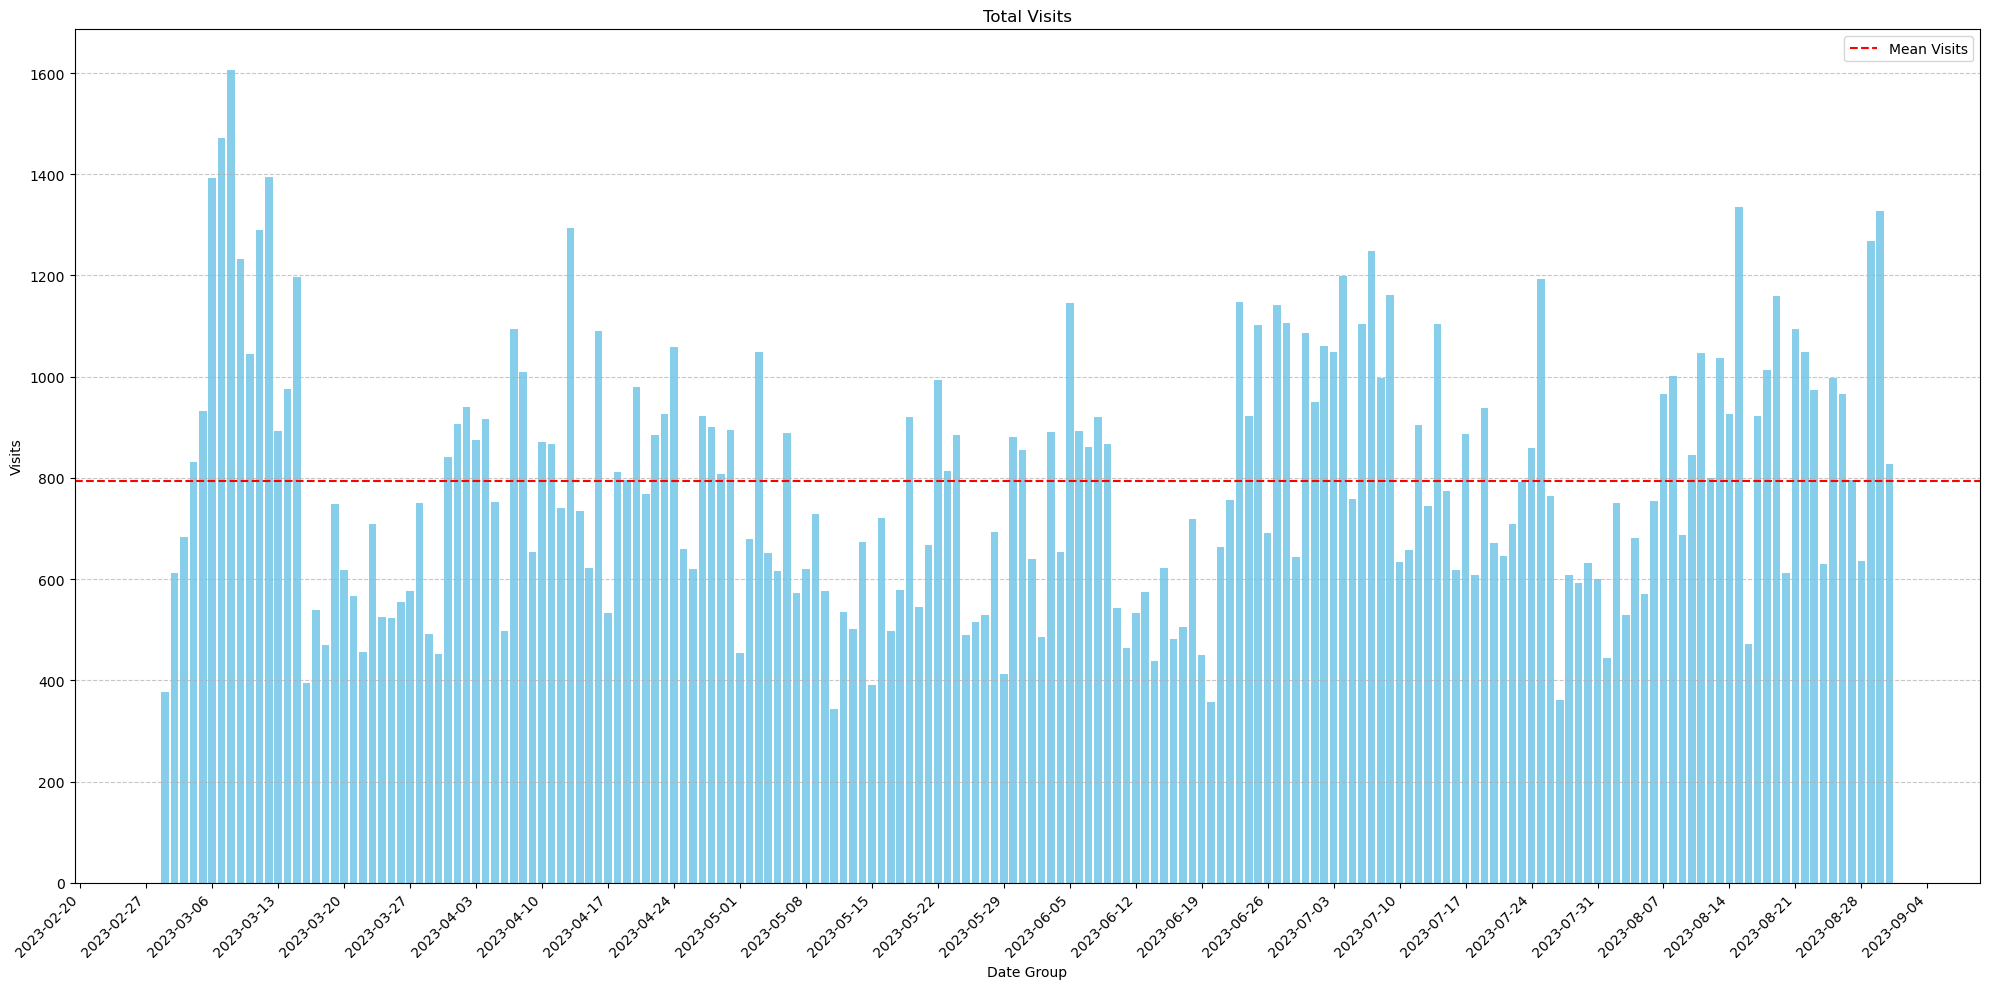

In [188]:
df_graf_visit_grouped = visits_grouped.copy(deep=True)

result = df_graf_visit_grouped.groupby('date_group')['visits'].sum().reset_index()
result['date_group'] = pd.to_datetime(result['date_group'])

plt.figure(figsize=(20, 10))
plt.bar(result['date_group'], result['visits'], color='skyblue')

plt.xlabel('Date Group')
plt.ylabel('Visits')
plt.title('Total Visits')

mondays = WeekdayLocator(MONDAY)
plt.gca().xaxis.set_major_locator(mondays)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45, ha='right')

mean_value = result['visits'].mean()
plt.axhline(y=mean_value, color='red', linestyle='--', label='Mean Visits')

plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.legend()
plt.tight_layout()

plt.savefig('charts/total_visits_chart.png', bbox_inches='tight')

plt.show()

### Итоговые визиты с разбивкой по платформам: web, android, ios

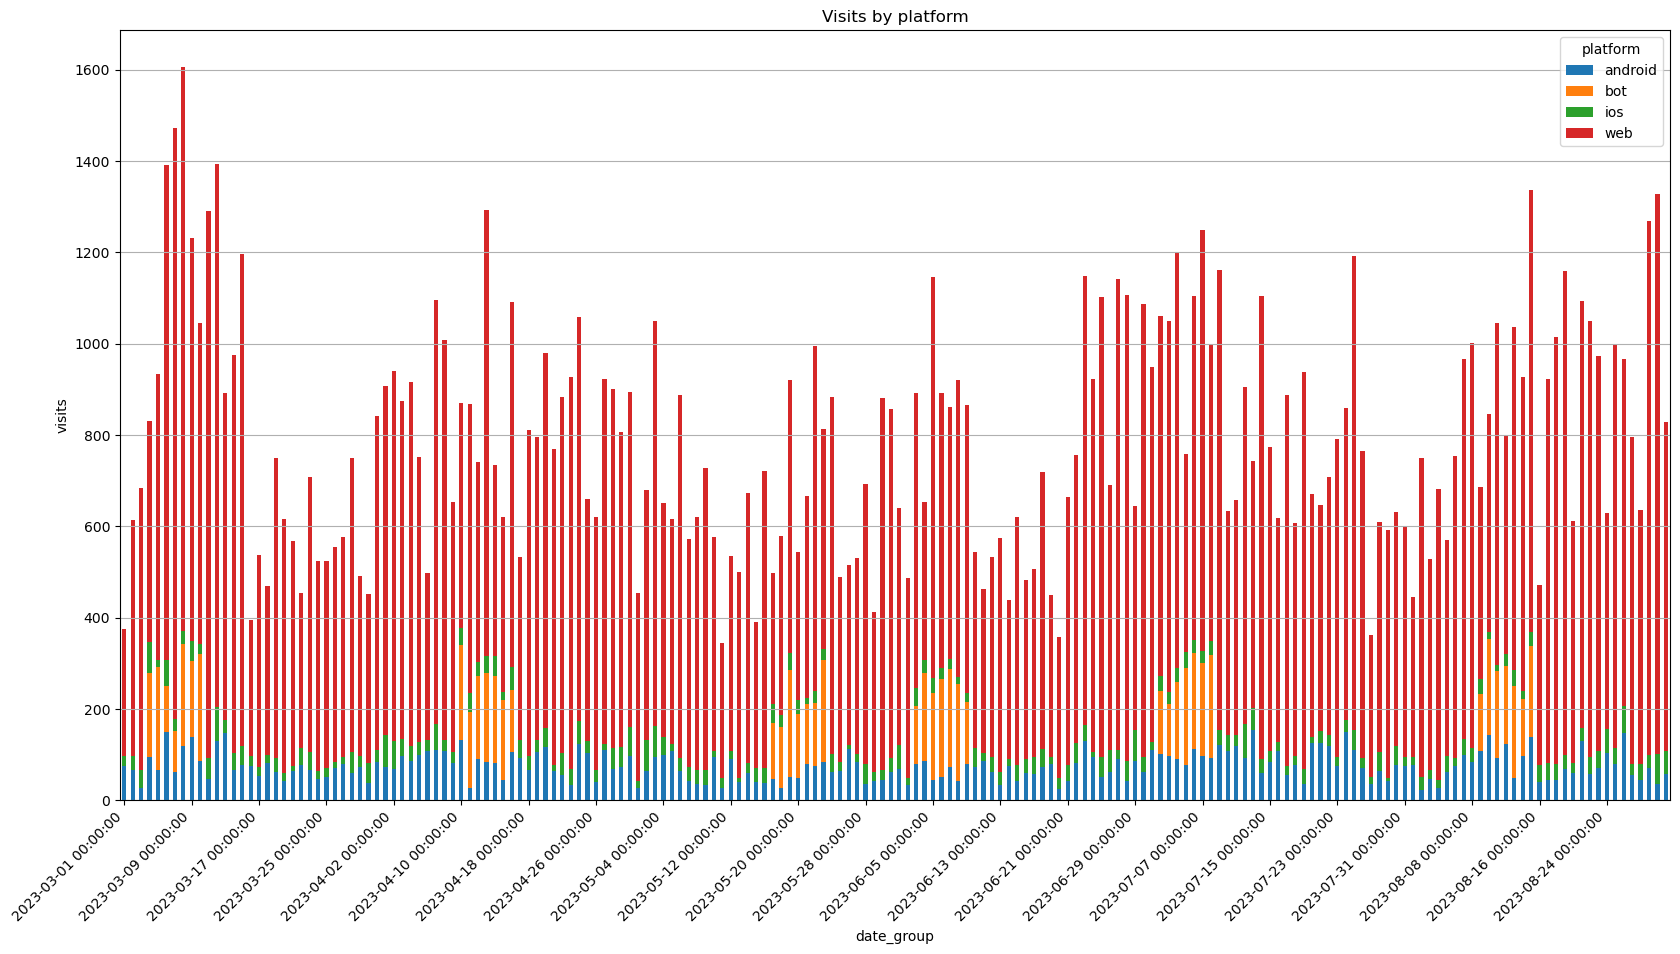

In [191]:
df_graf_visit_grouped_platform = visits_grouped.copy(deep=True)

df_graf_visit_grouped_platform['date_group'] = pd.to_datetime(df_graf_visit_grouped_platform['date_group'])

fig, ax = plt.subplots(figsize=(20, 10))

df_graf_visit_grouped_platform.groupby(['date_group', 'platform']).sum()['visits'].unstack().plot(kind='bar', stacked=True, ax=ax)

ax.set_xlabel('date_group')
ax.set_ylabel('visits')
ax.set_title('Visits by platform')

ax.legend(title='platform')

ax.yaxis.grid(True)

plt.xticks(rotation=45, ha='right')

ax.xaxis.set_major_locator(plt.MaxNLocator(30))

plt.savefig('charts/total_visits_by_platform.png', bbox_inches='tight')

plt.show()

### Итоговые регистрации

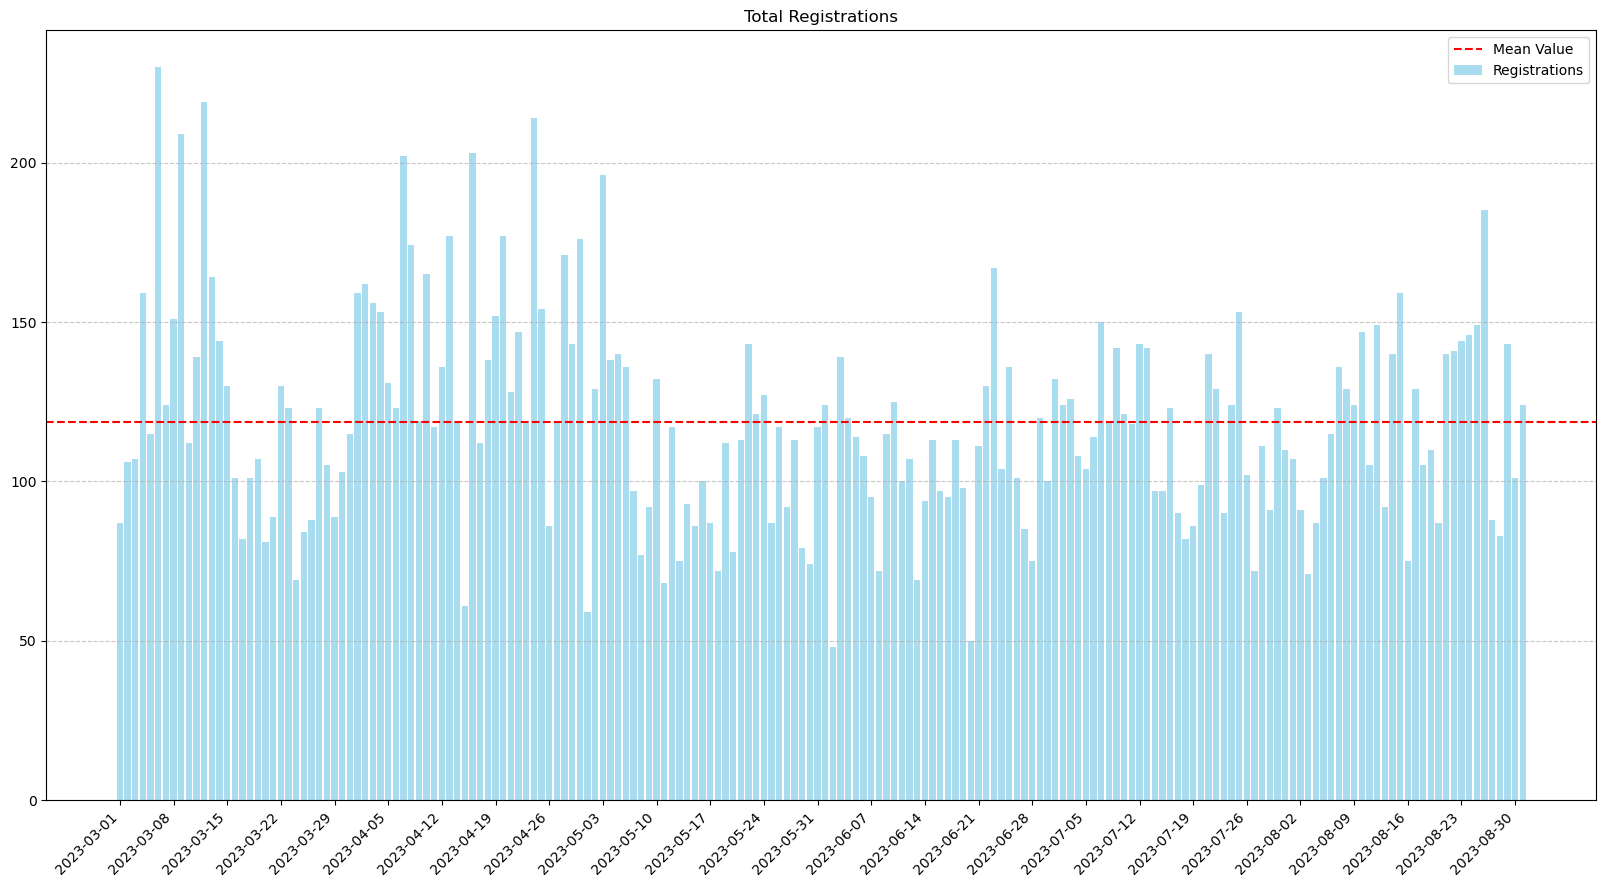

In [194]:
df_graf_registrations_grouped = registrations_grouped.copy(deep=True)

df_graf_registrations_grouped = df_graf_registrations_grouped.groupby('date_group')['registrations'].sum().reset_index()

plt.figure(figsize=(20, 10))

plt.bar(df_graf_registrations_grouped['date_group'], df_graf_registrations_grouped['registrations'], color='skyblue', alpha=0.7, label='Registrations')

mean_value = df_graf_registrations_grouped['registrations'].mean()
plt.axhline(y=mean_value, color='red', linestyle='--', label='Mean Value')

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.title('Total Registrations')

plt.xticks(df_graf_registrations_grouped['date_group'][::7], rotation=45, ha='right')

plt.legend()

plt.savefig('charts/total_registrations.png')

plt.show()

### Итоговые регистрации с разбивкой по платформе: web, android, ios

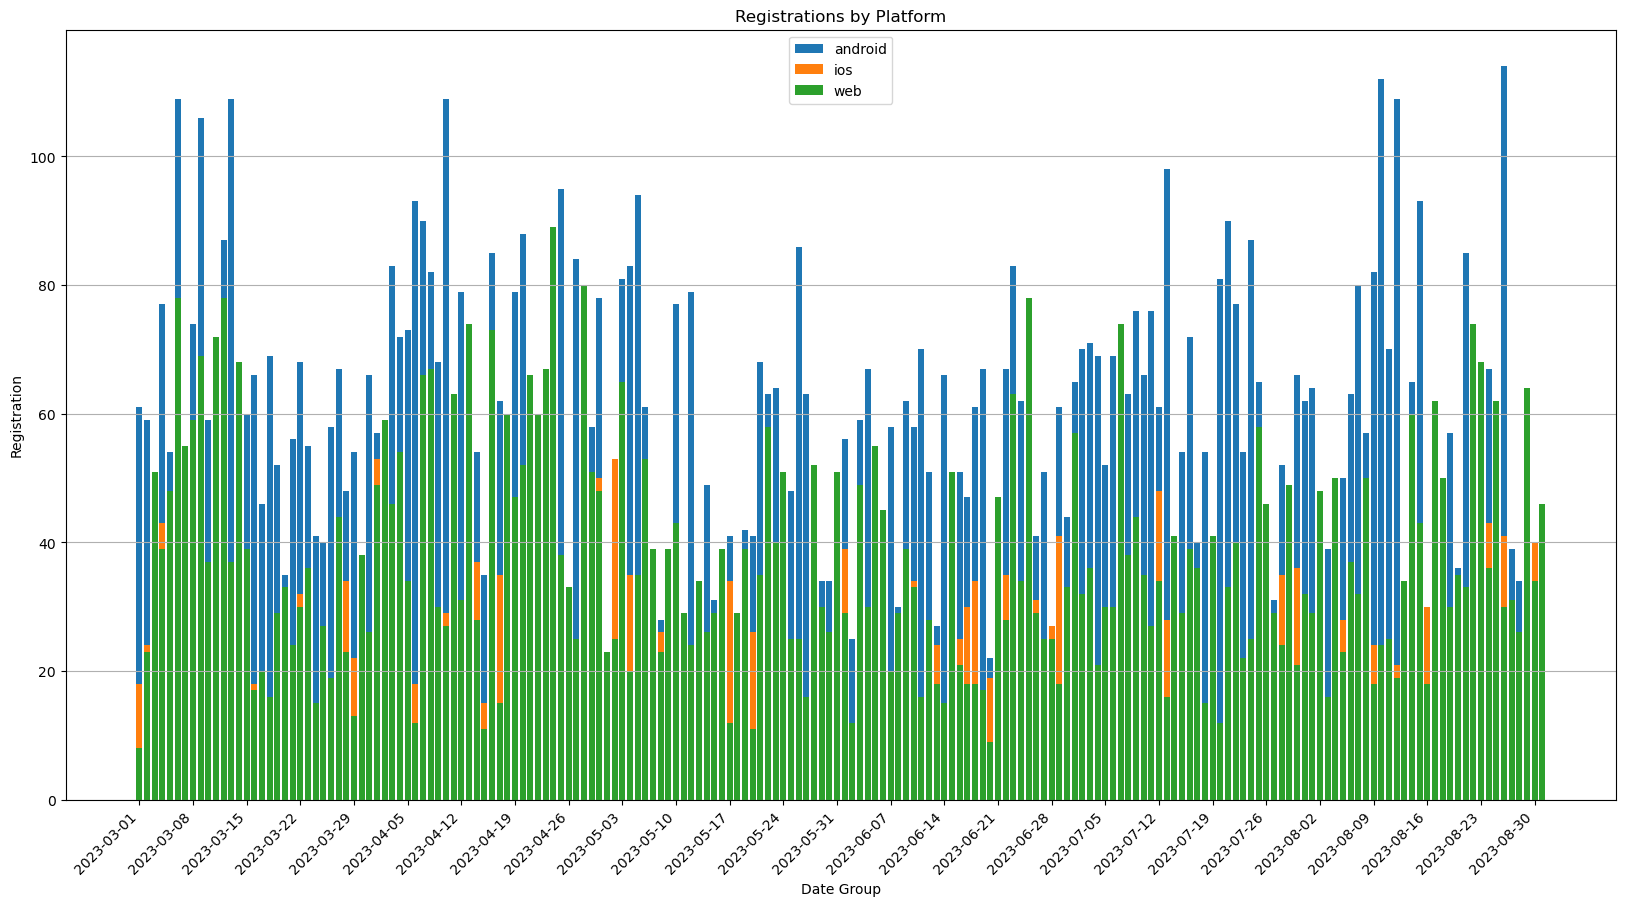

In [197]:
df_registrations_copy = df_regs.copy(deep=True)

df_registrations_copy['date_group'] = pd.to_datetime(df_registrations_copy['datetime'], format='%a, %d %b %Y %H:%M:%S GMT').dt.strftime('%Y-%m-%d')

grouped_df = df_registrations_copy.groupby(['date_group', 'platform']).size().reset_index(name='registration')

fig, ax = plt.subplots(figsize=(20, 10))

for platform in grouped_df['platform'].unique():
    platform_data = grouped_df[grouped_df['platform'] == platform]
    ax.bar(platform_data['date_group'], platform_data['registration'], label=platform)

ax.set_xlabel('Date Group')
ax.set_ylabel('Registration')
ax.set_title('Registrations by Platform')
ax.legend()

ax.grid(True, axis='y')

x_labels = grouped_df['date_group'].unique()[::7]
ax.set_xticks(x_labels)
ax.set_xticklabels(x_labels, rotation=45, ha='right')

plt.savefig('charts/total_registrations_by_platform.png')

plt.show()

### Конверсия по каждой платформе

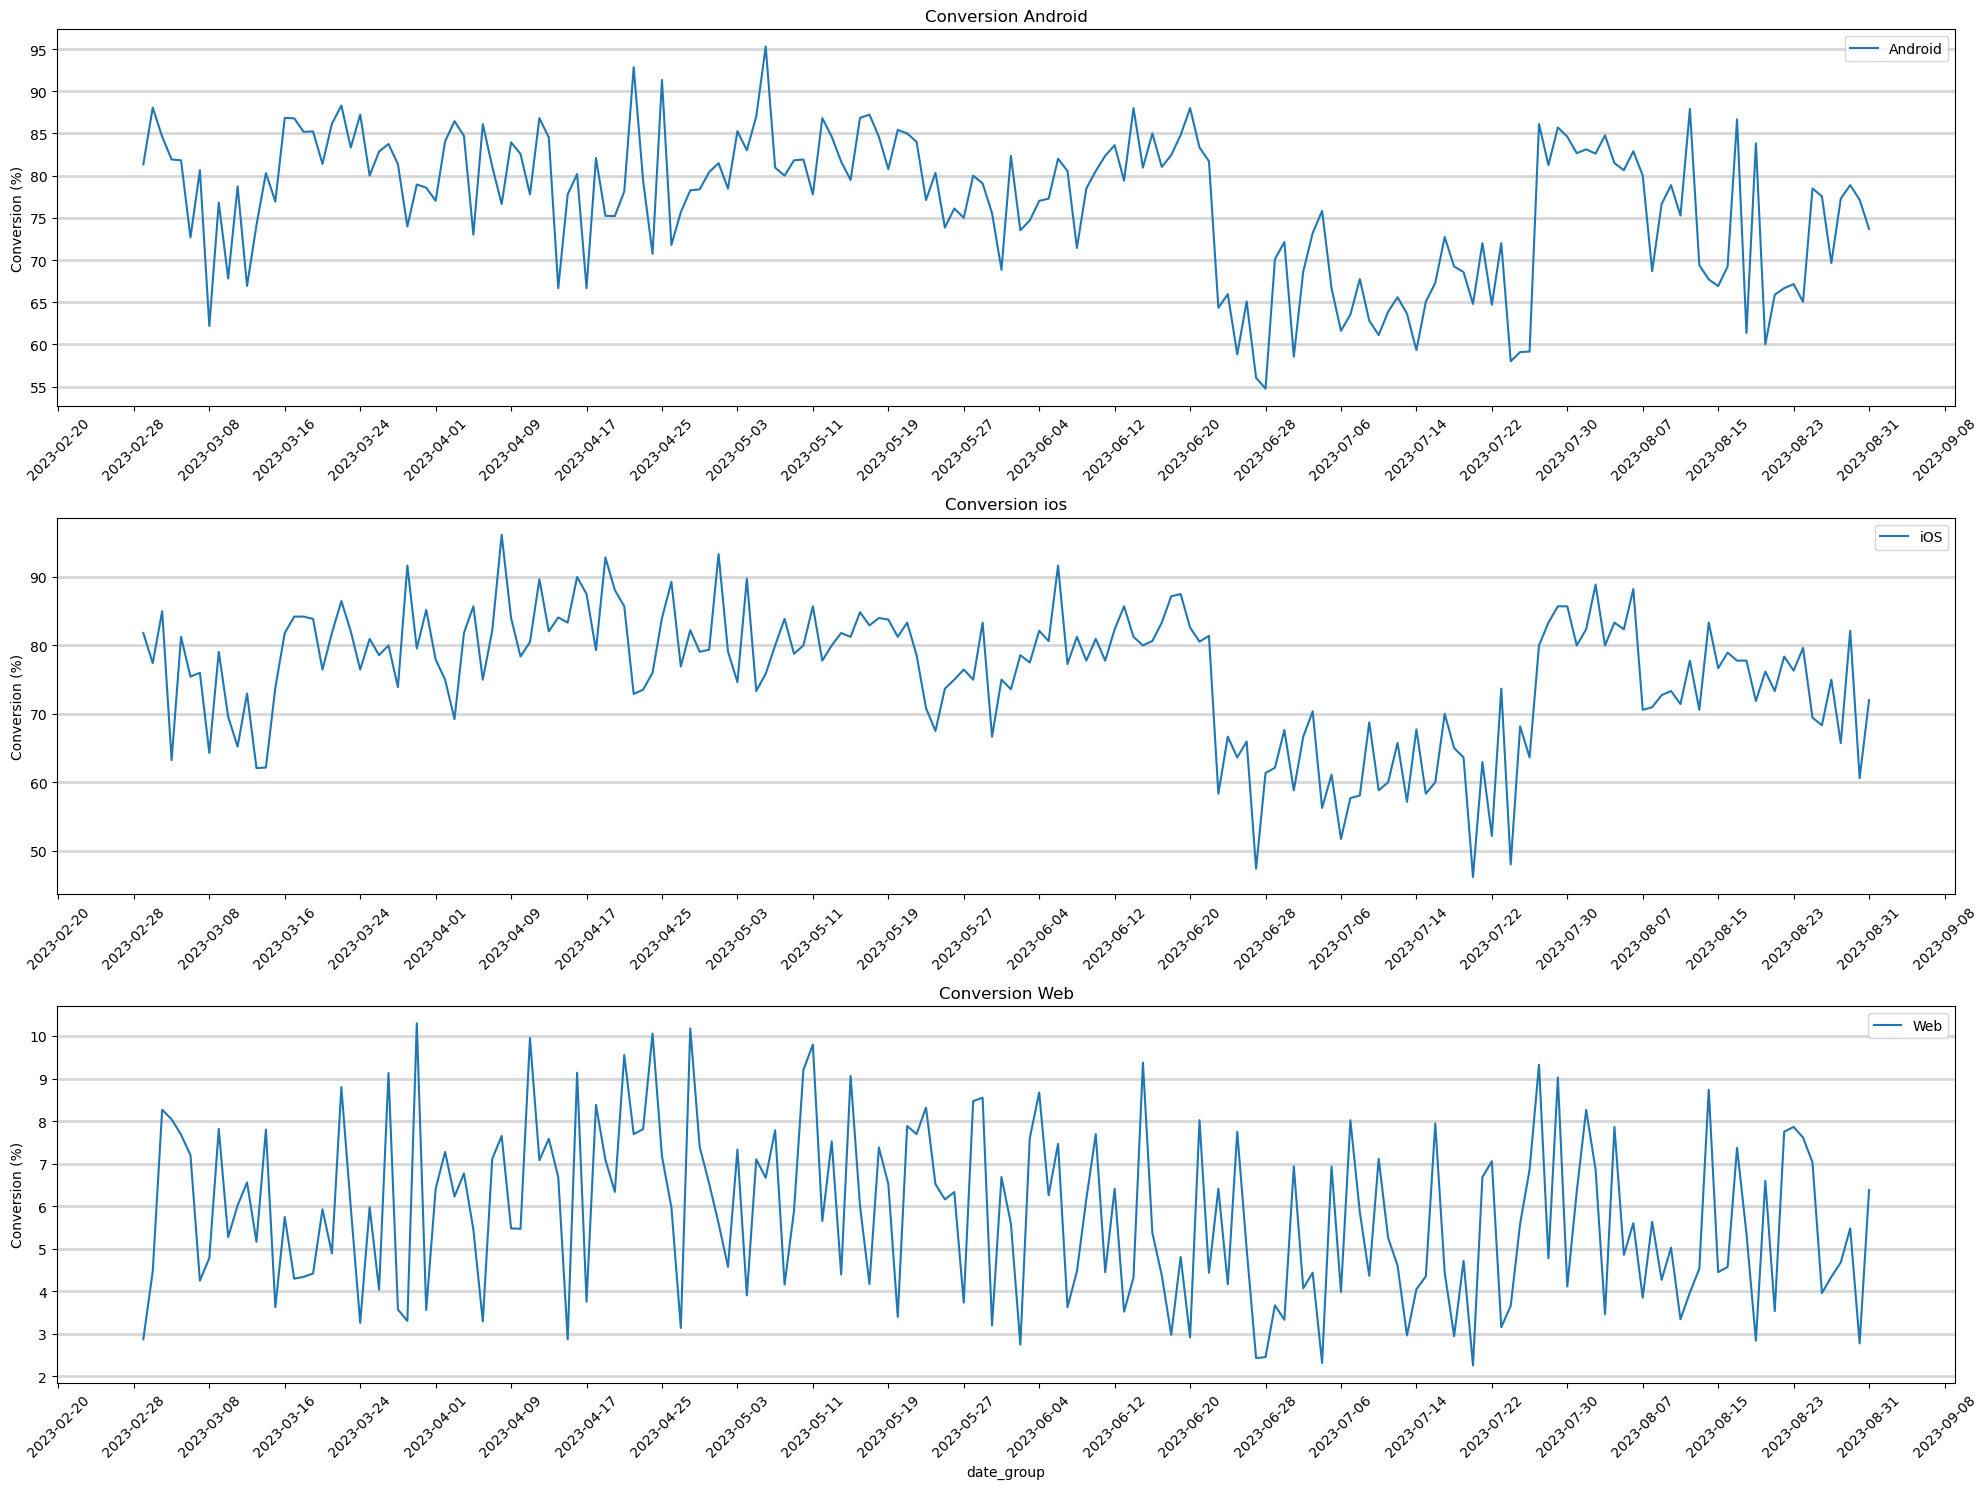

In [200]:
df_conversion_copy = merged_df.copy(deep=True)

android_data = df_conversion_copy[df_conversion_copy['platform'] == 'android']
ios_data = df_conversion_copy[df_conversion_copy['platform'] == 'ios']
web_data = df_conversion_copy[df_conversion_copy['platform'] == 'web']

fig, axs = plt.subplots(3, 1, figsize=(20, 15), sharex=False, sharey=False)

axs[0].plot(android_data['date_group'], android_data['conversion'], label='Android')
axs[0].set_title('Conversion Android')
axs[0].set_ylabel('Conversion (%)')
axs[0].legend()
axs[0].grid(True, linestyle='-', linewidth=2, alpha=0.5, which='both', axis='y', markevery=2)
axs[0].tick_params(axis='x', rotation=45)  # Поворот меток оси x
axs[0].xaxis.set_major_locator(plt.MaxNLocator(nbins=30))

axs[1].plot(ios_data['date_group'], ios_data['conversion'], label='iOS')
axs[1].set_title('Conversion ios')
axs[1].set_ylabel('Conversion (%)')
axs[1].legend()
axs[1].grid(True, linestyle='-', linewidth=2, alpha=0.5, which='both', axis='y', markevery=2)
axs[1].tick_params(axis='x', rotation=45) 
axs[1].xaxis.set_major_locator(plt.MaxNLocator(nbins=30)) 

axs[2].plot(web_data['date_group'], web_data['conversion'], label='Web')
axs[2].set_title('Conversion Web')
axs[2].set_xlabel('date_group')
axs[2].set_ylabel('Conversion (%)')
axs[2].legend()
axs[2].grid(True, linestyle='-', linewidth=2, alpha=0.5, which='both', axis='y', markevery=2)
axs[2].tick_params(axis='x', rotation=45) 
axs[2].xaxis.set_major_locator(plt.MaxNLocator(nbins=30))

plt.tight_layout()

plt.savefig('charts/conversion_by_platform.png')

plt.show()

### Средняя конверсия

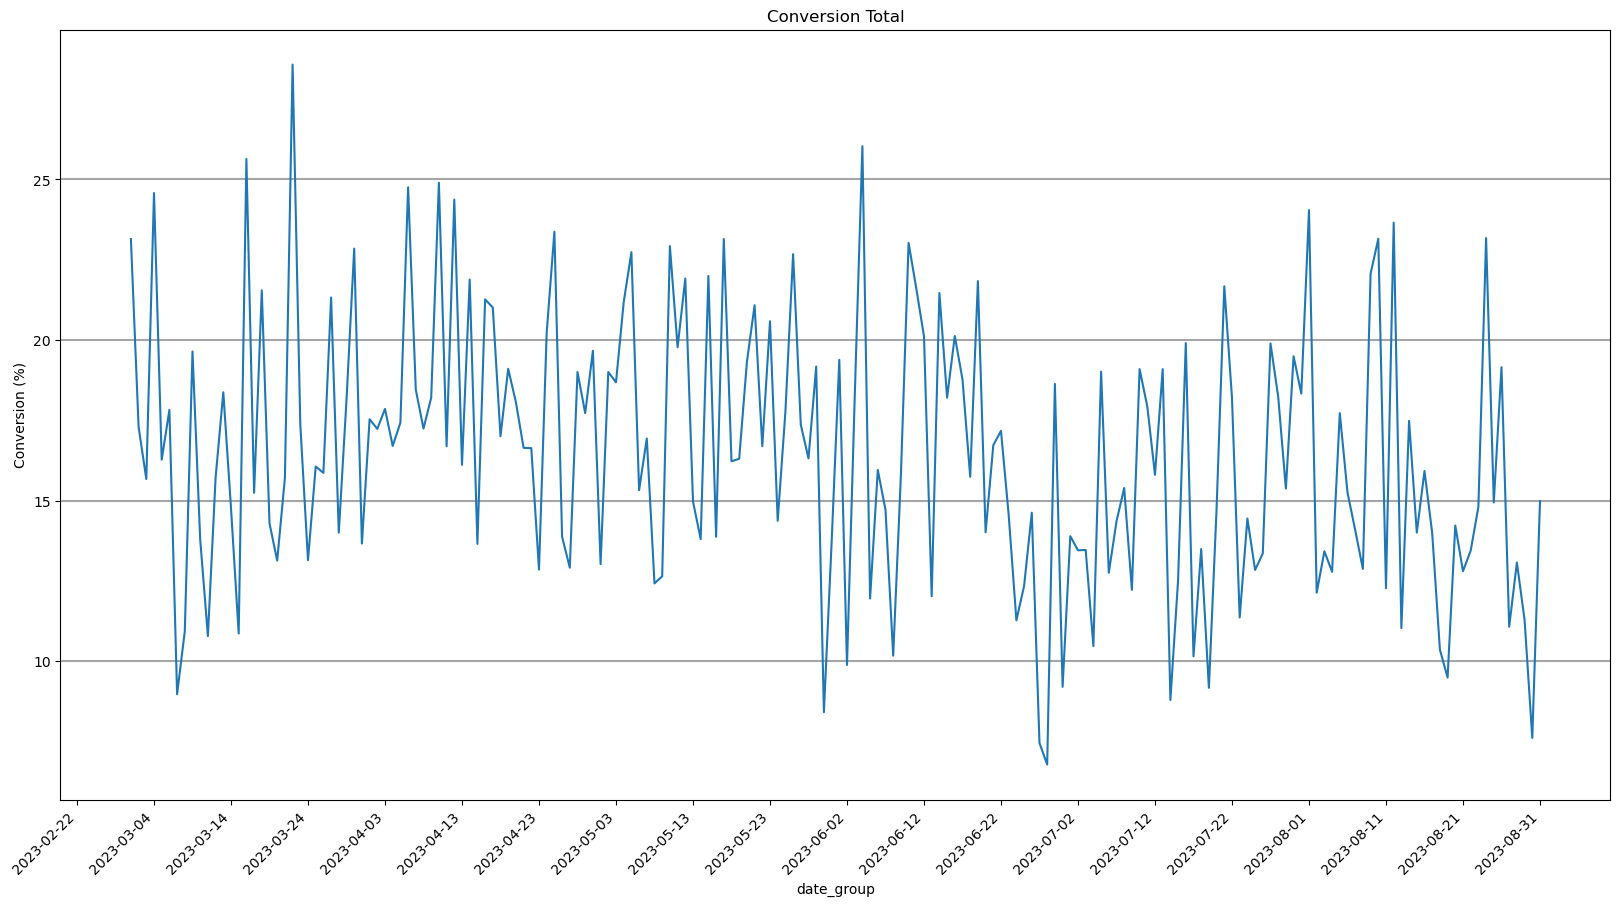

In [203]:
df_conversion_total = merged_df.copy(deep=True)

grouped_df = df_conversion_total.groupby('date_group').agg({'visits': 'sum', 'registrations': 'sum'})

grouped_df['conversion'] = (grouped_df['registrations'] / grouped_df['visits'] * 100).round(2)

plt.figure(figsize=(20, 10))
plt.plot(grouped_df.index, grouped_df['conversion'], linestyle='-')

plt.title('Conversion Total')
plt.xlabel('date_group')
plt.ylabel('Conversion (%)')

plt.xticks(df_graf_registrations_grouped['date_group'][::7], rotation=45, ha='right')

plt.grid(which='major', axis='y', linestyle='-', linewidth=1.5, color='gray', alpha=0.7)

plt.gca().xaxis.set_major_locator(MultipleLocator(10))

plt.savefig('charts/total_average_conversion.png')

plt.show()

### Стоимость реклам

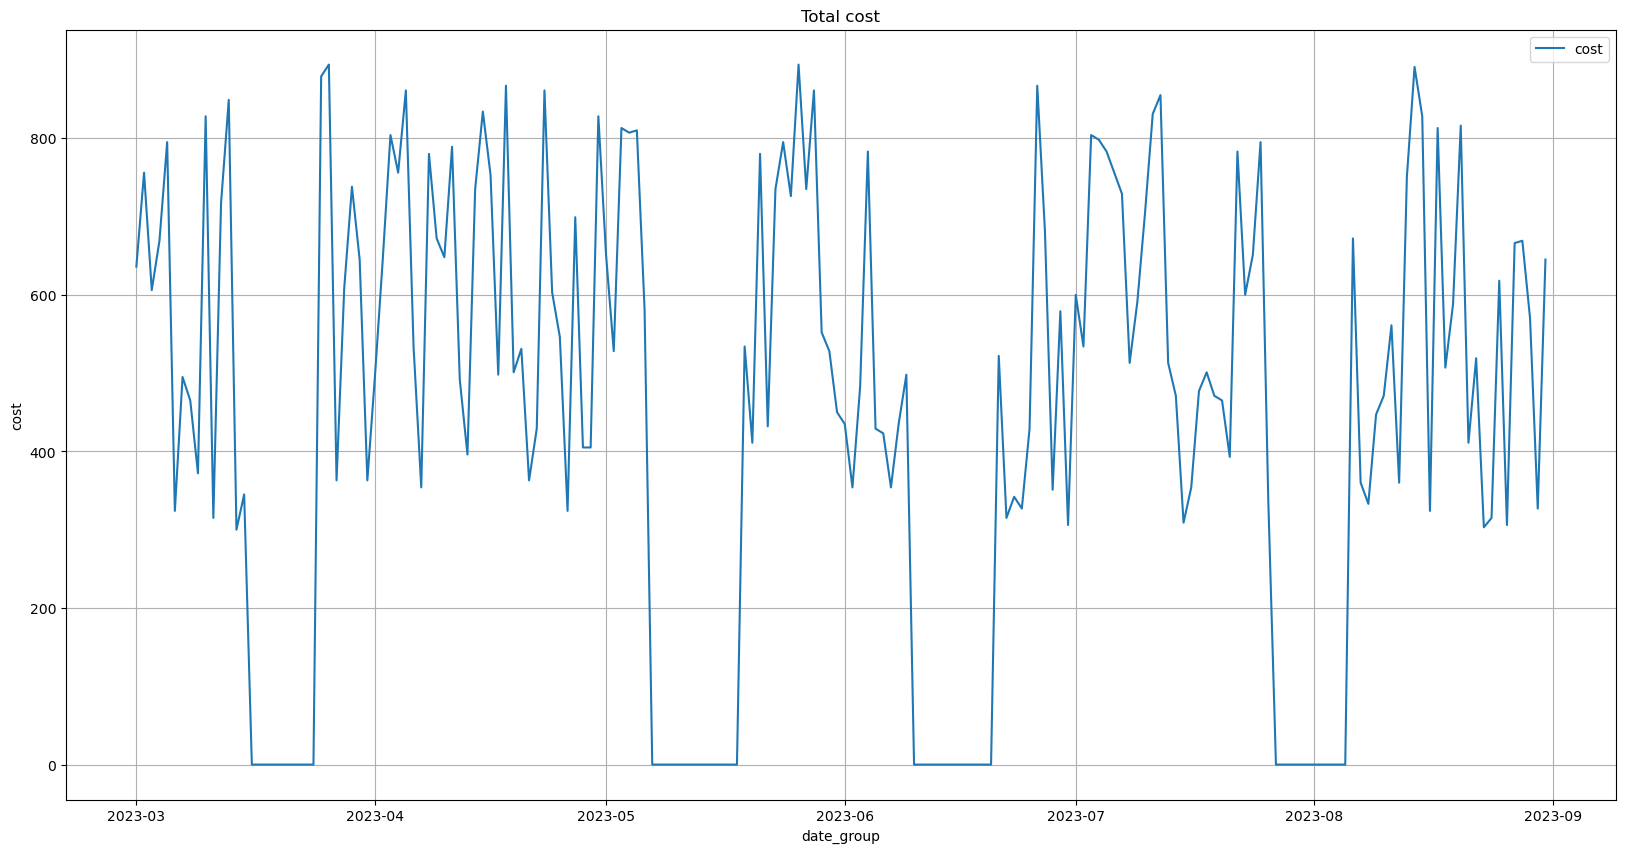

In [206]:
df_ads_total = result_df.copy(deep=True)

df_ads_total = df_ads_total.groupby('date_group')['cost'].sum().reset_index()

df_ads_total.plot(x='date_group', y='cost', kind='line', linestyle='-', figsize=(20, 10))

plt.title('Total cost')
plt.xlabel('date_group')
plt.ylabel('cost')
plt.grid(True)

plt.savefig('charts/ads_cost_total.png')

plt.show()

### Визиты за весь период с цветовым выделением рекламной кампании

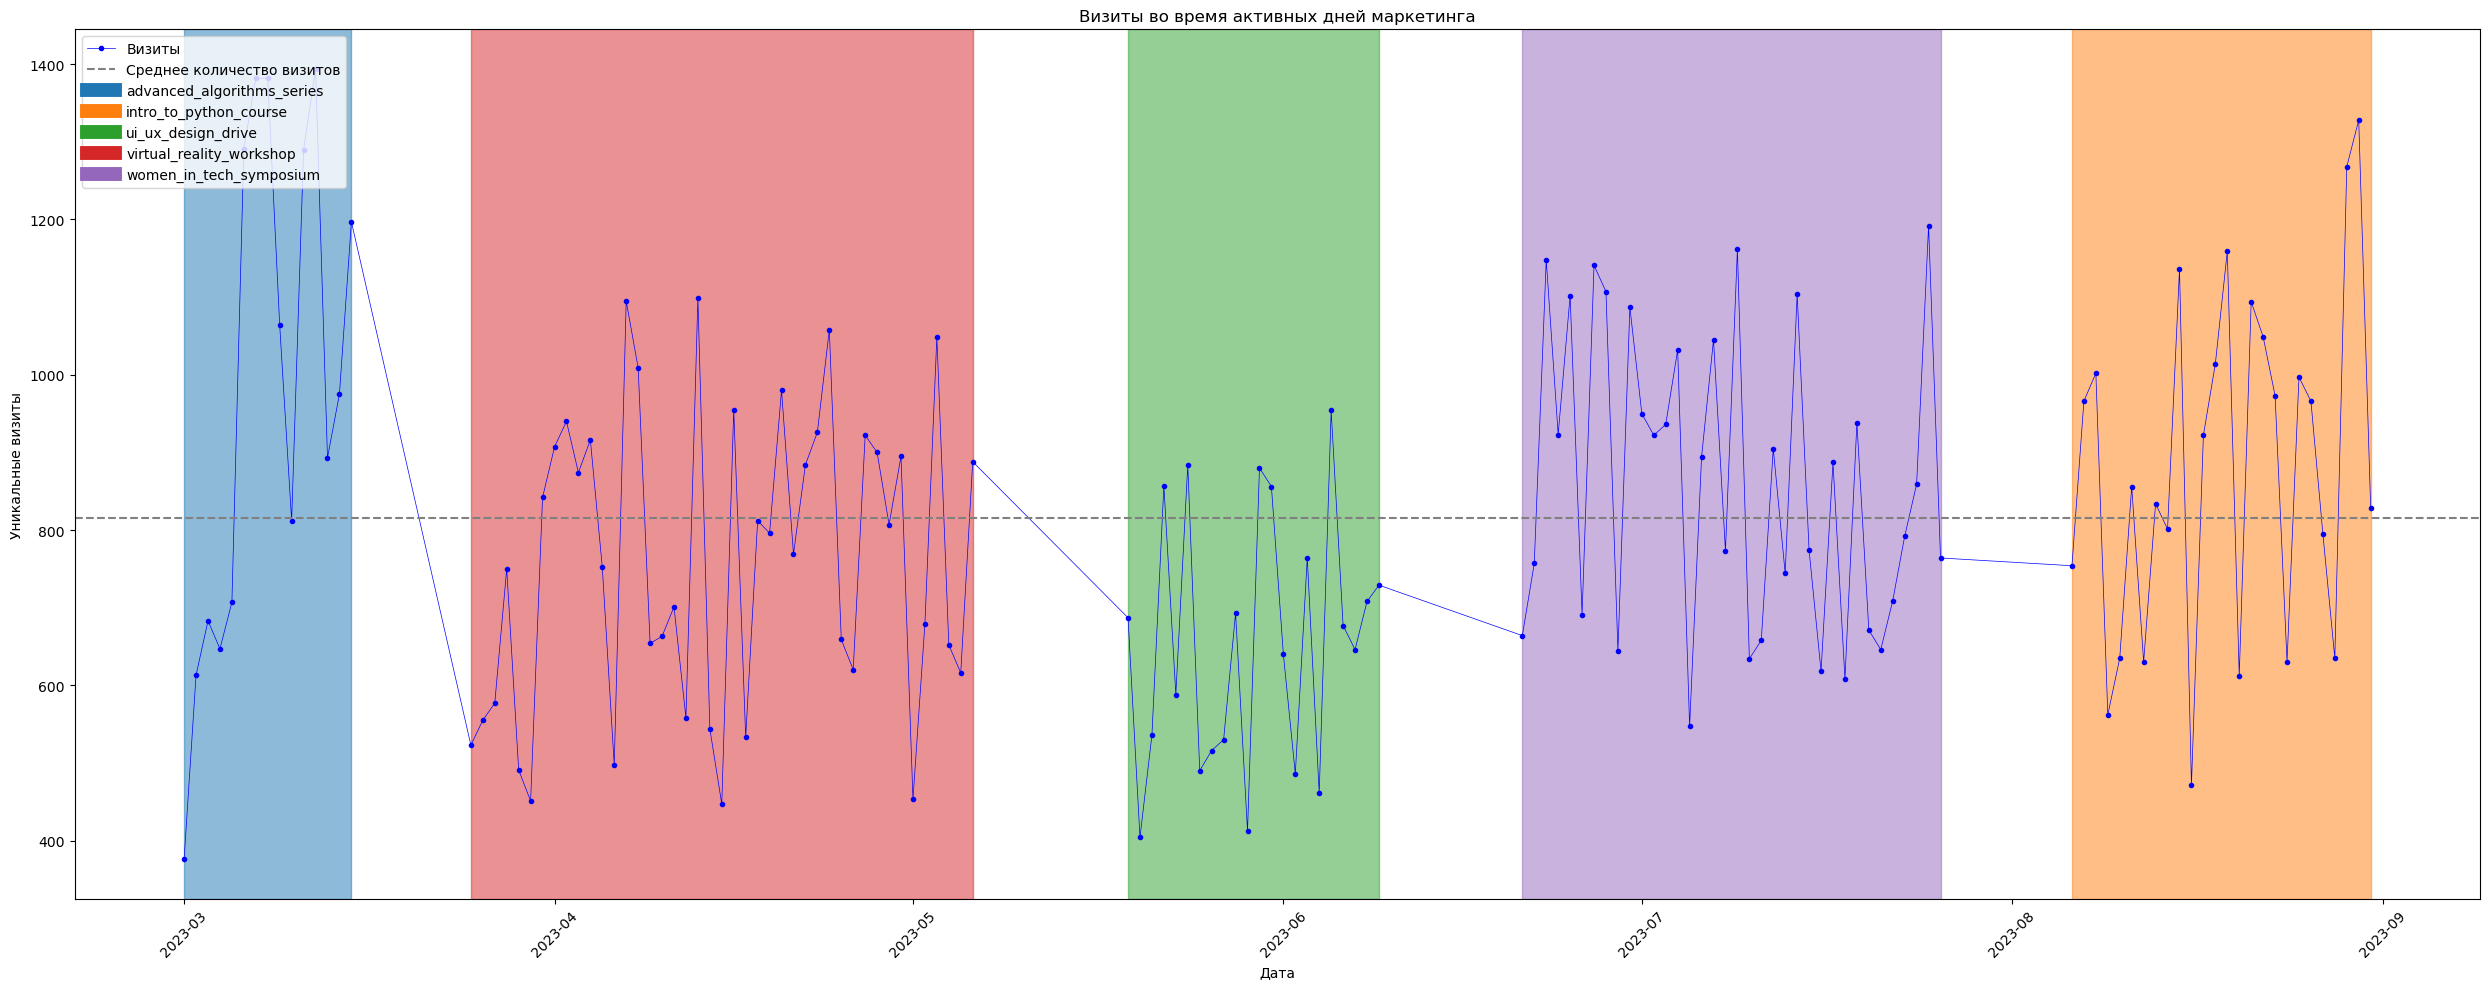

In [209]:
visits_from_utm_campaign = result_df.groupby(['date_group', 'utm_campaign']).agg({'visits':'sum'}).reset_index()
ads_periods = visits_from_utm_campaign[['utm_campaign', 'date_group']].groupby('utm_campaign').apply(lambda x : x.loc[(x['date_group'] == x['date_group'].min()) | (x['date_group'] == x['date_group'].max())]).reset_index(drop=True)
ads_start = ads_periods.groupby('utm_campaign')['date_group'].agg('min').reset_index()
ads_start.columns = ['utm_campaign', 'start'] 
ads_end = ads_periods.groupby('utm_campaign')['date_group'].agg('max').reset_index()
ads_end.columns = ['utm_campaign', 'end'] 
ads_from_start_to_end = ads_start.merge(ads_end)
ads_from_start_to_end['start'] = pd.to_datetime(ads_from_start_to_end['start'], format='%Y-%m-%d')
ads_from_start_to_end['end'] = pd.to_datetime(ads_from_start_to_end['end'], format='%Y-%m-%d')
ads_from_start_to_end = ads_from_start_to_end.replace(['2023-04-06'],'2023-04-05')
ads_from_start_to_end = ads_from_start_to_end.replace(['2023-04-08'],'2023-04-09')
ads_from_start_to_end = ads_from_start_to_end.replace(['2023-07-28'],'2023-07-29')

# Построение графика визитов с выделением рекламных кампаний
fig, ax = plt.subplots(figsize=(25, 10))

# Построение графика визитов
ax.plot(visits_from_utm_campaign['date_group'], visits_from_utm_campaign['visits'], color='blue', label='Визиты',
         marker='o', linewidth=0.5, ms=3)

# Вычисление и отображение среднего количества визитов
average_visits = visits_from_utm_campaign['visits'].mean()
ax.axhline(y=average_visits, color='gray', linestyle='--', label="Среднее количество визитов")

# Используем уникальные цвета из TABLEAU_COLORS для создания словаря соответствия кампании и цвета
campaign_colors = dict(zip(ads_from_start_to_end['utm_campaign'].unique(), colors.TABLEAU_COLORS.values()))

# Цикл для выделения периодов рекламных кампаний
for _, row in ads_from_start_to_end.iterrows():
    ax.axvspan(row['start'], row['end'], color=campaign_colors[row['utm_campaign']], alpha=0.5)
    ax.plot([], [], color=campaign_colors[row['utm_campaign']], linewidth=10, label=row['utm_campaign'])

# Добавление легенды с учетом выделения кампаний
ax.legend(loc='upper left')

# Дополнительные настройки графика
plt.title('Визиты во время активных дней маркетинга')
plt.xlabel('Дата')
plt.ylabel('Уникальные визиты')
plt.xticks(rotation=45)
plt.tight_layout()

# Показываем график
plt.savefig('charts/visits_active_days.png')
plt.show()

### Регистрации за весь период с цветовым выделением рекламной кампании

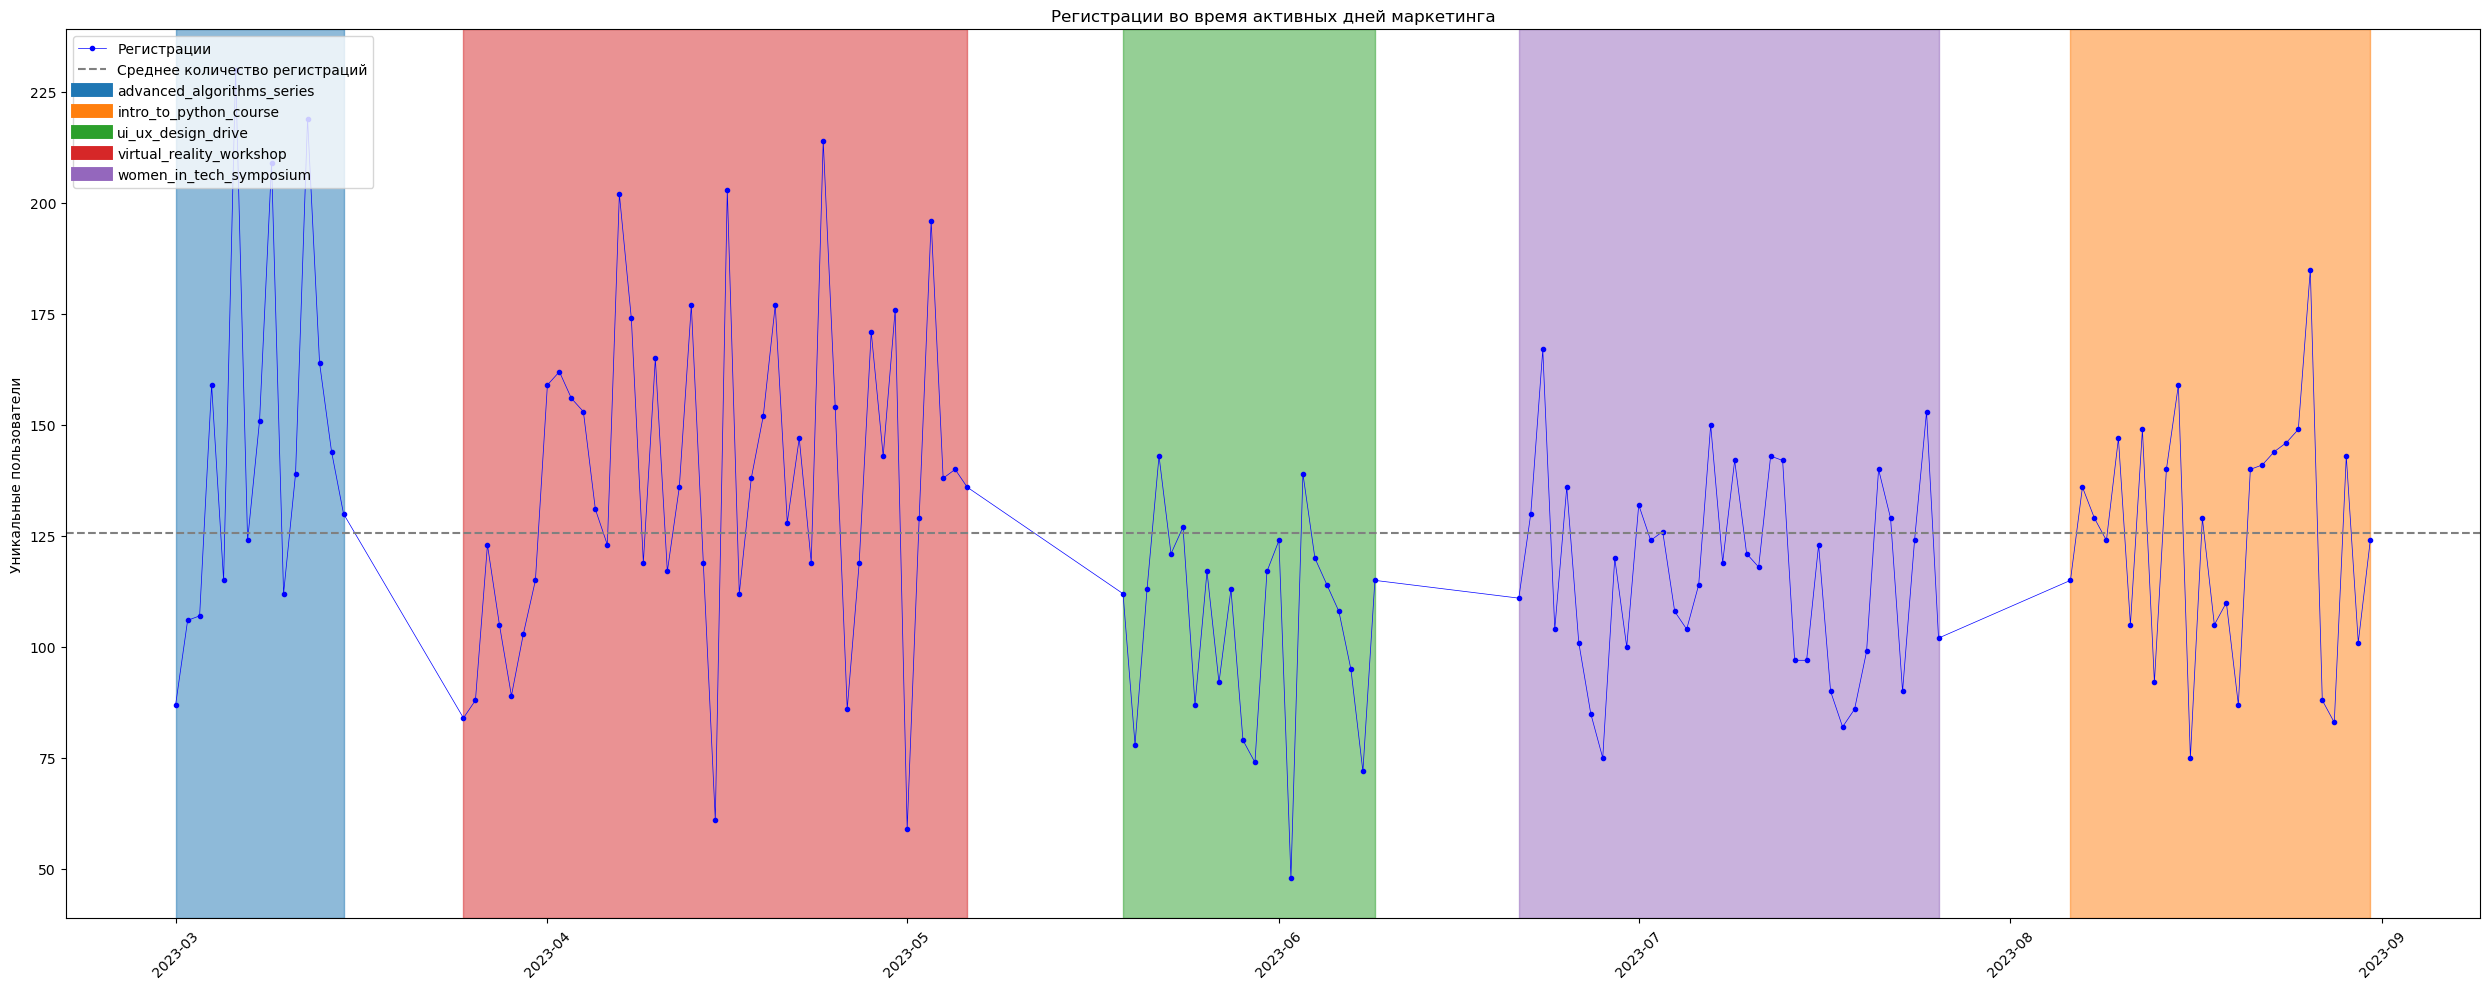

In [212]:
registrations_from_utm_campaign = result_df.groupby(['date_group', 'utm_campaign']).agg({'registrations':'sum'}).reset_index()

# Создание фигуры для графика
plt.figure(figsize=(25, 10))
plt.title('Регистрации во время активных дней маркетинга')
plt.ylabel('Уникальные пользователи')
plt.xticks(rotation=45)

# Построение графика регистраций
plt.plot(registrations_from_utm_campaign['date_group'], registrations_from_utm_campaign['registrations'], color='blue', label='Регистрации',
         marker='o', linewidth=0.5, ms=3)

# Вывод среднего количества регистраций
plt.axhline(y=registrations_from_utm_campaign['registrations'].mean(), color='gray', linestyle='--', label="Среднее количество регистраций")

# Создание словаря цветов для каждой рекламной кампании
campaign_colors = dict(zip(ads_from_start_to_end['utm_campaign'].unique(), colors.TABLEAU_COLORS.values()))

# Выделение на графике периодов рекламных кампаний
for _, row in ads_from_start_to_end.iterrows():
    plt.axvspan(row['start'], row['end'], color=campaign_colors[row['utm_campaign']], alpha=0.5)
    plt.plot([], [], color=campaign_colors[row['utm_campaign']], linewidth=10, label=row['utm_campaign'])

# Добавление легенды
plt.legend(loc='upper left')

# Сохранение графика в файл
plt.tight_layout()
plt.savefig('charts/registration_active_days.png')
plt.show()